## K-means for crustal and lithospheric configurations

The overall goal for this workbook is to quantitatively investigate how $K$-means clustering clusters the anomalies, in order to see if this can lead to automated classification. Although $K$-means is an unsupervised learning technique, one can classify using $K$-means by looking at which points are in the same cluster as known examples. These known examples can be synthetic or real world data, but crucially the lithospheric configuration must be known reasonably accurately.

The benefits of this method over others is that the "training" time is considerably lower.

In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reading in raw data.
anom_df = pd.read_csv("bag_anom.csv")
anom_df.describe()

,x (km),Airy anom (mGal),Bouguer anom (mGal),Geoid anom (mGal)
count,74.000000,74.000000,74.000000,74.000000
mean,1991.183919,0.254370,-13.811054,-1.701378
std,1158.191535,24.654458,41.233023,32.449100
min,73.740000,-49.369000,-106.680000,-87.201000
25%,1028.550000,-14.855500,-31.447250,-11.340750
50%,1991.285000,0.626500,-3.374000,-4.345000
75%,2939.055000,15.243500,10.118000,6.677000
max,3965.210000,56.109000,57.201000,73.660000


In [3]:
input_list = ['Airy anom (mGal)', 'Bouguer anom (mGal)', 'Geoid anom (mGal)']
features = anom_df[input_list].values

In [4]:
# Elbow method
min_SSEs = []
for k in range(2,15):
    kmeans_obj = KMeans(init="random",
                    n_clusters=k,
                    n_init=100,
                    max_iter=300,
                    random_state=42)
    kmeans_obj.fit(features)
    min_SSEs.append(kmeans_obj.inertia_)

Text(0, 0.5, 'Min SSE')

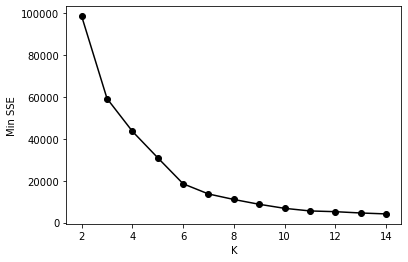

In [5]:
plt.scatter(x = range(2,15), y = min_SSEs, color = (0,0,0))
plt.plot(range(2,15), min_SSEs, color = (0,0,0))
plt.xlabel(xlabel = 'K')
plt.ylabel(ylabel = 'Min SSE')

In [6]:
knee_loc = KneeLocator(range(2,15),
                       min_SSEs,
                       curve = 'convex',
                       direction = 'decreasing')
knee_loc.elbow

6

The elbow is located at $K = 6$, which is fitting because we have 6 different configurations. Let us see how the predictions look for $K = 6$.

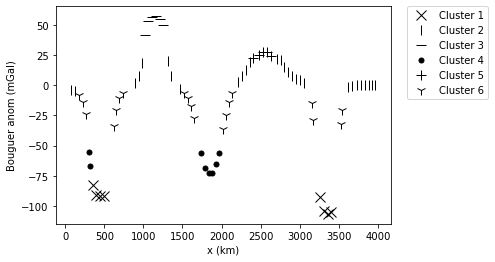

In [7]:
# Generating plots for the data.
k = 6
kmeans_obj = KMeans(init="random",
                    n_clusters=k,
                    n_init=100,
                    max_iter=300,
                    random_state=42)
kmeans_obj.fit(features)
anom_df['cluster'] = kmeans_obj.labels_

marker_dict = {0:'x',
               1:'|',
               2:'_',
               3:'.',
               4:'+',
               5:'1'}

groups = anom_df.groupby('cluster')
for name, group in groups:
    plt.plot(group['x (km)'],
             group['Bouguer anom (mGal)'],
             marker=marker_dict[name],
             linestyle='',
             markersize=10,
             label=name,
             color = (0,0,0))
plt.xlabel(xlabel = 'x (km)')
plt.ylabel(ylabel = 'Bouguer anom (mGal)')
plt.legend(bbox_to_anchor = (1.05,1), loc = 'upper left', borderaxespad = 0, labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])

There are several interesting characteristics of the plot. Using only these features, the $K$-means method just segments the data into bands, such that if the value of the anomalies fall into these bands they are allocated to that cluster. This presents classification issues with the crustal thickening and lithospheric thickening points, which are just assigned to the same cluster based on this banding. The banding also subdivides the default configuration into two groups, based on whether or not the points are above a value that is approximately zero. This leaves less clusters available to actually discern the groups of interest.

Immediately, this can be used to classify points near the stationary points relatively well, except for the crustal and lithospheric thickening. Currently, the model only considers the value of each individual anomaly separately, but we can artificially construct features that are a function of two or more anomalies, and see how these features are handled in the $K$-means method.

### Using quadratic features

In [8]:
# Generating quadratic features using
# difference of two squares and cross terms.
anom_df['f12(A,B)'] = anom_df['Airy anom (mGal)']**2 - anom_df['Bouguer anom (mGal)']**2
anom_df['f12(B,G)'] = anom_df['Bouguer anom (mGal)']**2 - anom_df['Geoid anom (mGal)']**2
anom_df['f12(A,G)'] = anom_df['Airy anom (mGal)']**2 - anom_df['Geoid anom (mGal)']**2
anom_df['f22(A,B)'] = anom_df['Airy anom (mGal)']*anom_df['Bouguer anom (mGal)']
anom_df['f22(B,G)'] = anom_df['Bouguer anom (mGal)']*anom_df['Geoid anom (mGal)']
anom_df['f22(A,G)'] = anom_df['Airy anom (mGal)']*anom_df['Geoid anom (mGal)']

In [9]:
quad_input_list = ['Airy anom (mGal)', 'Bouguer anom (mGal)', 'Geoid anom (mGal)',
              'f12(A,B)', 'f12(B,G)', 'f12(A,G)', 'f22(A,B)', 'f22(B,G)', 'f22(A,G)']
quad_features = anom_df[quad_input_list].values

In [10]:
# Elbow method
min_SSEs = []
for k in range(2,15):
    kmeans_obj = KMeans(init="random",
                    n_clusters=k,
                    n_init=100,
                    max_iter=300,
                    random_state=42)
    kmeans_obj.fit(quad_features)
    min_SSEs.append(kmeans_obj.inertia_)

Text(0, 0.5, 'Min SSE')

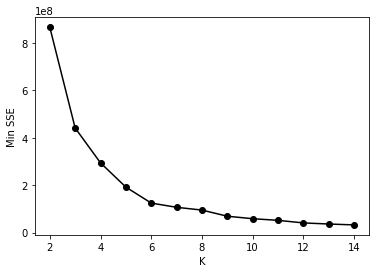

In [11]:
plt.scatter(x = range(2,15), y = min_SSEs, color = (0,0,0))
plt.plot(range(2,15), min_SSEs, color = (0,0,0))
plt.xlabel(xlabel = 'K')
plt.ylabel(ylabel = 'Min SSE')

In [12]:
knee_loc = KneeLocator(range(2,15),
                       min_SSEs,
                       curve = 'convex',
                       direction = 'decreasing')
knee_loc.elbow

5

Some calculations of this show the elbow at $K = 5$. We know that we have 6 different configurations, so we will just use $K = 6$ anyway.

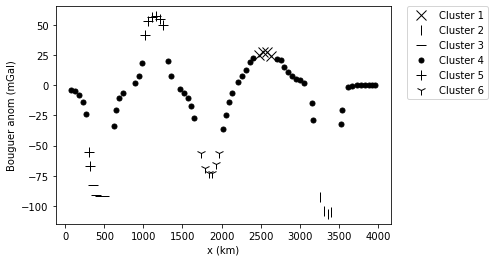

In [13]:
# Plotting the data.
k = 6
kmeans_obj = KMeans(init="random",
                    n_clusters=k,
                    n_init=100,
                    max_iter=300,
                    random_state=42)
kmeans_obj.fit(quad_features)
anom_df['corr cluster'] = kmeans_obj.labels_

groups = anom_df.groupby('corr cluster')
for name, group in groups:
    plt.plot(group['x (km)'],
             group['Bouguer anom (mGal)'],
             marker = marker_dict[name],
             linestyle='',
             markersize=10,
             label = name,
             color = (0,0,0))
plt.xlabel(xlabel = 'x (km)')
plt.ylabel(ylabel = 'Bouguer anom (mGal)')
plt.legend(bbox_to_anchor = (1.05,1), loc = 'upper left', borderaxespad = 0, labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])

This is a much closer classification to what we expect from the data. Now, we can see that the default configuration is clustered well, and we can discern between crustal and lithospheric thickening to a much better degree. There are still some misclassified points that are classified as crustal thinning instead of crustal thickening. However, this is a much stronger attempt at classifying using the $K$-means method.

Certainly, it seems that one can accurately classify the stationary points of the gravity and geoid anomalies. If one can determine the synthetic gravity and geoid anomalies close to stationary points, then one ought to be able to classify real world stationary anomaly points well using the $K$-means method.